## **Advanced Lane Finding Project**

### *by Maxim Taralov*

### Import the necessary libraries

In [1]:
import numpy as np
import cv2
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import glob
import pickle
import os
from moviepy.editor import VideoFileClip
%matplotlib inline

### Camera calibration

Define the camera calibration function. If the 'camera_info' file doesn't exist, it performs the calibration and saved the found parameters. If it exists, it reads the parameters from there.

In [2]:
def get_camera_calibration():
    if not os.path.exists('camera_info'):
        objsize_small = (9,5)
        objp_small = np.zeros((objsize_small[0]*objsize_small[1],3), np.float32)
        objp_small[:,:2] = np.mgrid[0:objsize_small[0], 0:objsize_small[1]].T.reshape(-1,2)
        objsize_large = (9,6)
        objp_large = np.zeros((objsize_large[0]*objsize_large[1],3), np.float32)
        objp_large[:,:2] = np.mgrid[0:objsize_large[0], 0:objsize_large[1]].T.reshape(-1,2)

        objpoints = []
        imgpoints = []

        images = glob.glob('./camera_cal/small/*.jpg')
        images.extend(glob.glob('./camera_cal/*.jpg'))
        criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)
        for idx, fname in enumerate(images):
            img = cv2.imread(fname)
            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

            if idx < 3:
                objsize = objsize_small
                objp = objp_small
            else:
                objsize = objsize_large
                objp = objp_large
            ret, corners = cv2.findChessboardCorners(gray, objsize)

            if ret == True:
                objpoints.append(objp)
                imgpoints.append(corners)
                # locate subpixles to increase accuracy
                cv2.cornerSubPix(gray,corners,(11,11),(-1,-1),criteria)
                cv2.drawChessboardCorners(img, objsize, corners, ret)
                cv2.imshow('img', img)
                cv2.waitKey(500)


        cv2.destroyAllWindows()

        ret, mtx, dist_coef, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, (img.shape[0:2]), None, None)
        mydict = {}
        mydict['mtx'] = mtx
        mydict['dist_coef'] = dist_coef
        mydict['rvecs'] = rvecs
        mydict['tvecs'] = tvecs

        with open('camera_info', 'wb') as pickle_file:
            pickle.dump(mydict, pickle_file)
    else:
        with open('camera_info', 'rb') as pickle_file:
            camera_dict = pickle.load(pickle_file)

        mtx = camera_dict['mtx']
        dist_coef = camera_dict['dist_coef']
    return mtx, dist_coef

mtx, dist_coef = get_camera_calibration()

Let us now test the found (or read) calibration parameters

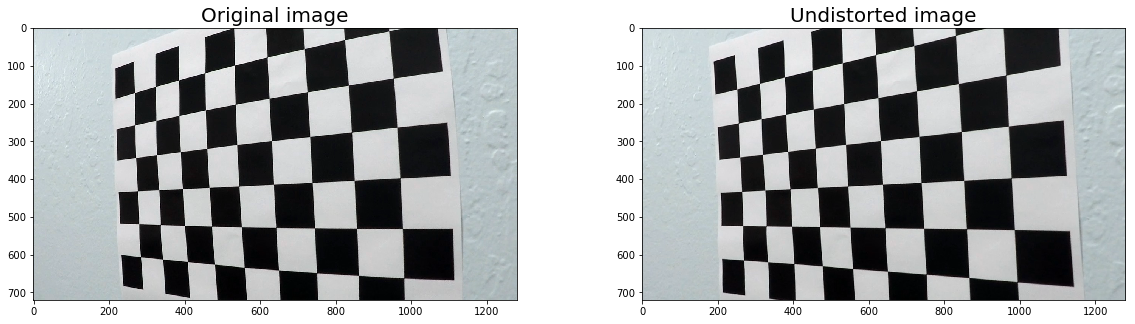

In [3]:
img = cv2.imread('./camera_cal/calibration4.jpg')

img_undist = cv2.undistort(img, mtx, dist_coef)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,5))
ax1.imshow(img)
ax1.set_title('Original image', fontsize=20)
ax2.imshow(img_undist)
ax2.set_title('Undistorted image', fontsize=20)
fig.savefig('./output_images/camera_calibration.png', bbox_inches = 'tight')

And this is a test on one of the provided test images

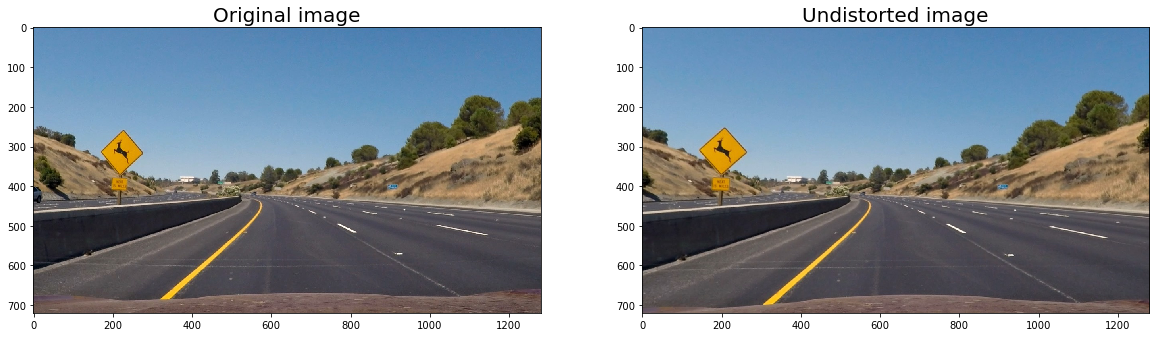

In [4]:
img = mpimg.imread('./test_images/test2.jpg')
img_undist = cv2.undistort(img, mtx, dist_coef)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original image', fontsize=20)
ax2.imshow(img_undist)
ax2.set_title('Undistorted image', fontsize=20)
mpimg.imsave('./output_images/test2_undist.jpg', img_undist)

### Thresholding

The next function defines the function that find the mask with the lane pixels. It uses only color information and expects an image that already passed a perspective transform (that is to say, it expects only a top-down view of the road)

In [5]:
def color_mask(warped_image, num_levels = 6):
    """
    - warped_image -- a top-down view of the road
    - num_level -- for high-contrast, it gives the number of slices, 
    where historgram equalization is peformed; 6 seems to work okay
    
    Returns the mask with the lane pixels
    """
    img_luv = cv2.cvtColor(warped_image, cv2.COLOR_RGB2LUV)
    height = img_luv.shape[0]
    width = img_luv.shape[1]
    offset = height//num_levels
    margin = 100
    mask = np.zeros((warped_image.shape[0:2]), dtype = bool)
    L = img_luv[:,:,0]
    bright_lums = np.sum(L>220)
    mean_lum = np.mean(L)
    if bright_lums < 1500:
        # for low contrast images this works better
        v = img_luv[:,:,2]
        if mean_lum > 110 and mean_lum < 135:
            yellow_mask = v > 145
        else:
            yellow_mask = v > 150
        white_mask = L > 190
        mask = (yellow_mask) | (white_mask)
    else:
        # for high contrast window-wise equalized L and v channels gives me clearest line detection
        for level in range(num_levels):
            window = img_luv[height-(level+1)*offset:height-level*offset]
            L = window[:,:,0]
            v = window[:,:,2]
            L_equ_window = cv2.equalizeHist(L)
            v_equ_window = cv2.equalizeHist(v)
            #mean_lum = np.mean(L)
            mask[height-(level+1)*offset:height-level*offset, :] = (v_equ_window > 247) | (L_equ_window > 252)
            
    return mask

### Find the matrix for the perspective transform

In [6]:
def get_warp_mat(img, vis = False, tl_adj = 0, tr_adj = 0, bl_adj = 0, br_adj = 0, y_offset = 480, output_filename = None):
    """
    - img -- the image which to use for finding the warping matrix
    - vis -- if True, it show the color mask, the original image and
    the warped version
    - tl_adj, tr_adj, bl_adj, br_adj -- adjustments for the x-axis 
    values for the four corners of the trapezoid - top left, top right, 
    bottom left, bottom right
    - y_offset -- the maximal position, where the upper boundary of
    the trapezoid can lie.
    
    Semi-automatic computation of the warping matrix. If vis is True,
    the function shows the found trapezoid on the original image as
    well as the warped version of the image. Consequently, the basic
    trapezoid can be adjusted, until satisfactory results are achieved.
    """
    img_luv = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
    L = img_luv[:,:,0]
    u = img_luv[:,:,1]
    v = img_luv[:,:,2]

    L_equ = cv2.equalizeHist(L)
    mask_luv = (v > 160) | (L_equ > 242)

    binary_image = mask_luv.astype(np.uint8)
    binary_image = cv2.undistort(binary_image, mtx, dist_coef)
    img_shape = binary_image.shape
    middle_col = img_shape[1]//2
    left_pts = binary_image[y_offset:,:middle_col]
    right_pts = binary_image[y_offset:,middle_col:]
    nonzero_left_y = np.nonzero(np.sum(left_pts, axis = 1))
    nonzero_left_x = np.nonzero(np.sum(left_pts, axis = 0))
    nonzero_right_y = np.nonzero(np.sum(right_pts, axis = 1))
    nonzero_right_x = np.nonzero(np.sum(right_pts, axis = 0))
    intersect_y = np.intersect1d(nonzero_left_y, nonzero_right_y)
    bottom_y = np.max(intersect_y)-1
    bottom_x_left = np.max(np.nonzero(left_pts[bottom_y]))
    bottom_x_right = np.min(np.nonzero(right_pts[bottom_y])) + middle_col
    bottom_y += y_offset

    top_x_right = np.min(nonzero_right_x)
    top_y = np.max(np.nonzero(right_pts[:,top_x_right]))
    top_x_left = np.max(np.nonzero(left_pts[top_y]))
    top_x_right += middle_col
    top_y += y_offset

    top_x_left += tl_adj
    top_x_right += tr_adj
    bottom_x_left += bl_adj
    bottom_x_right += br_adj
    
    pt1 = (top_x_left, top_y)
    pt2 = (top_x_right, top_y)
    pt3 = (bottom_x_left, bottom_y)
    pt4 = (bottom_x_right, bottom_y)
    src_pts = np.float32((pt3, pt4, pt2, pt1))
    
    pt_out_x1 = 300
    pt_out_x2 = img.shape[1] - 300
    pt_out_y1 = img.shape[0] - 5
    pt_out_y2 = 400#450
    pt_out1 = (pt_out_x1, pt_out_y1)
    pt_out2 = (pt_out_x2, pt_out_y1)
    pt_out3 = (pt_out_x2, pt_out_y2)
    pt_out4 = (pt_out_x1, pt_out_y2)
    dst_pts = np.float32([pt_out1, pt_out2, pt_out3, pt_out4])
    M = cv2.getPerspectiveTransform(src_pts, dst_pts)
    M_inv = cv2.getPerspectiveTransform(dst_pts, src_pts)

    if vis == True:
        print('Source points:', src_pts) # show coordinates in case of need for adjustments 
        print('Destination points:',dst_pts)
        fig, ax = plt.subplots(1,1,figsize=(10,10))
        ax.imshow(mask_luv, cmap='gray')
        ax.set_title('Mask for finding the points', fontsize=18)
        img_linesdrawn = cv2.undistort(img, mtx, dist_coef)
        line_thickness = 1
        cv2.line(img_linesdrawn, pt1, pt2, (255, 0, 0), line_thickness)
        cv2.line(img_linesdrawn, pt2, pt4, (255, 0, 0), line_thickness)
        cv2.line(img_linesdrawn, pt3, pt1, (255, 0, 0), line_thickness)
        cv2.line(img_linesdrawn, pt3, pt4, (255, 0, 0), line_thickness)

        warped = cv2.warpPerspective(img_linesdrawn, M, (img_shape[1::-1]), flags = cv2.INTER_NEAREST)

        fig, ax = plt.subplots(1,2,figsize=(20,20))
        ax[0].imshow(img_linesdrawn)
        ax[0].set_title('Undistored image with source points', fontsize = 18)
        ax[1].imshow(warped)
        ax[1].set_title('Warped image', fontsize = 18)
        #mpimg.imsave('automarked.jpg', img_linesdrawn)
        #mpimg.imsave('autowarped.jpg', warped)
        if output_filename is not None:
            fig.savefig(output_filename, bbox_inches = 'tight')
    
    return M, M_inv



Let us now combine the previous two functions and test them

Source points: [[  272.   689.]
 [ 1050.   689.]
 [  732.   480.]
 [  556.   480.]]
Destination points: [[ 300.  715.]
 [ 980.  715.]
 [ 980.  400.]
 [ 300.  400.]]


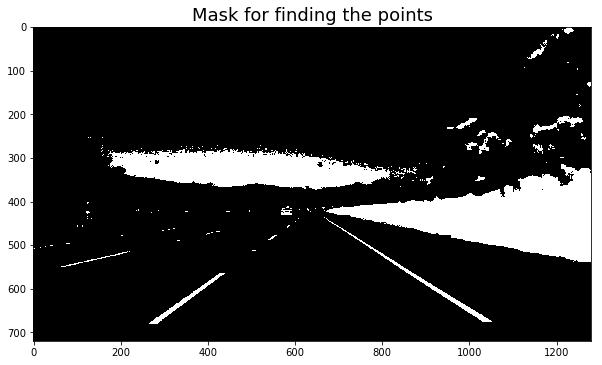

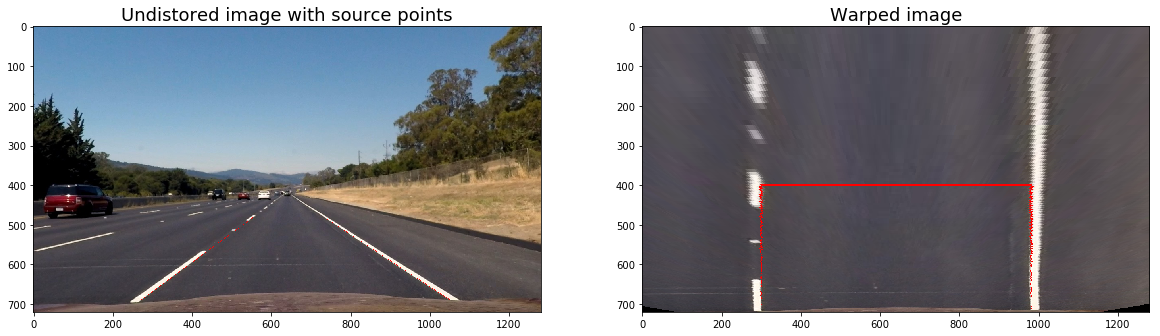

In [7]:
# get the transform with an image that has straight lines
warp_base = mpimg.imread('project_warp.jpg')
M, M_inv = get_warp_mat(warp_base, vis = True, tl_adj=1, tr_adj=-1, output_filename = 'output_images/warping.png') # this uses parameter adjustments

Let us now transform one of the test images

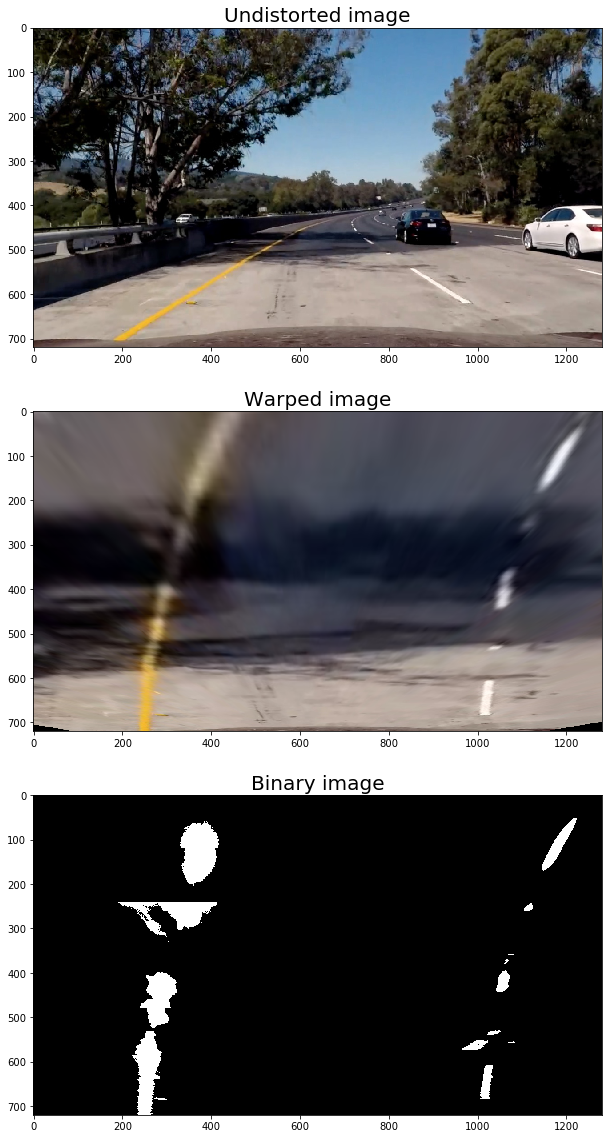

In [8]:
# now apply it to another image
img_base = mpimg.imread('test_images/test5.jpg')
img_undist = cv2.undistort(img_base, mtx, dist_coef)
img_warped = cv2.warpPerspective(img_undist, M, img_base.shape[1::-1])
img_binary = color_mask(img_warped).astype(np.uint8)*255

fig, ax = plt.subplots(3,1,figsize=(15,20))
ax[0].imshow(img_undist)
ax[0].set_title('Undistorted image', fontsize = 20)
ax[1].imshow(img_warped)
ax[1].set_title('Warped image', fontsize = 20)
ax[2].imshow(img_binary, cmap = 'gray')
ax[2].set_title('Binary image', fontsize = 20)
fig.savefig('output_images/coloring.png', bbox_inches = 'tight')

### Finding the lane points

The next two functions find the lane points in a binary warped image. The first function uses a sliding window apporoach and rejects windows if the input is too noisy. The second function uses a previous fit and selects the points around it in a certain window.

In [9]:
def find_lane_points_reset(binary_warped, num_windows):
    """
    Use a sliding window to find points
    """
    image_height = binary_warped.shape[0]
    image_width = binary_warped.shape[1]
    window_height = image_height//num_windows
    window_width = 150
    minpix = 50
    first_row = image_height-window_height
    last_row = image_height
    row_sum = np.sum(binary_warped[last_row-image_height//3:last_row, :], axis = 0)
    conv = row_sum
    center_left = np.argmax(conv[:image_width//2])
    center_right = np.argmax(conv[image_width//2:]) + image_width//2
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    left_lane_inds = []
    right_lane_inds = []
    
    left_misses = 1
    right_misses = 1
    one_mat = (binary_warped>0).astype(np.uint8)
    for window_nr in range(num_windows):
        row_sum = np.sum(one_mat[first_row:last_row, :], axis = 0)
        min_x_left = max(0, center_left-window_width)
        max_x_left = center_left+window_width
        max_l_ind = np.argmax(row_sum[min_x_left:max_x_left])+min_x_left
        med_l = np.median(row_sum[max(0, max_l_ind-window_width):max_l_ind+window_width])
        good_left_inds = np.empty((0), dtype=np.int64)
        #if med_l < 150:
        if med_l < 30:
            if np.sum(row_sum[max_l_ind-window_width:max_l_ind+window_width]) > minpix:
                center_left = max_l_ind
                min_x_left = max(0, center_left-window_width)
                max_x_left = center_left+window_width
            good_left_inds = ((nonzeroy >= first_row) & (nonzeroy <= last_row) & (nonzerox >= min_x_left) & (nonzerox <= max_x_left)).nonzero()[0]
    
        min_x_right = max(0, center_right-window_width)
        max_x_right = center_right+window_width
        max_r_ind = np.argmax(row_sum[min_x_right:image_width])+min_x_right
        med_r = np.median(row_sum[max(0, max_r_ind-window_width):max_r_ind+window_width])
        good_right_inds = np.empty((0), dtype=np.int64)
        #print(med_r)
        # if found pixels are too noisy, reject
        if med_r < 30:
            if np.sum(row_sum[max_r_ind-window_width:max_r_ind+window_width]) > minpix:
                center_right = max_r_ind
                min_x_right = max(0, center_right-window_width)
                max_x_right = center_right+window_width
            good_right_inds = ((nonzeroy >= first_row) & (nonzeroy <= last_row) & (nonzerox >= min_x_right) & (nonzerox <= max_x_right)).nonzero()[0]
        
        first_row -= window_height
        last_row -= window_height
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            center_left = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            center_right = np.int(np.mean(nonzerox[good_right_inds]))
            
    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 
 
    return leftx, lefty, rightx, righty

def find_lane_points_update(binary_warped, left_fit, right_fit):
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    #margin = 100
    margin = 80
    #margin = 150
    left_pred = np.polyval(left_fit, nonzeroy)
    right_pred = np.polyval(right_fit, nonzeroy)
    left_lane_inds = ((nonzerox > (left_pred - margin)) & (nonzerox < (left_pred + margin))) 
    right_lane_inds = ((nonzerox > (right_pred - margin)) & (nonzerox < (right_pred + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    return leftx, lefty, rightx, righty

The following class stores the data for a line.

In [10]:
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None

### Curvature and fit evaluation

In [11]:
def find_curvature(fit, y):
    """
    Compute the curvature of a second-order polynomial fit a point y
    """
    dxdy2 = np.polyval(np.polyder(fit, 2), y)
    dxdy = np.polyval(np.polyder(fit, 1), y)
    return (1+dxdy**2)**1.5/np.abs(dxdy2)

def evaluate_fits(left_line, right_line):
    """
    This function evaluates the quality of the two line fits and computes the final fit values
    """
    if left_line.best_fit is None or right_line.best_fit is None:
        left_line.best_fit = left_line.current_fit
        right_line.best_fit = right_line.current_fit
        return 
    
    y_min = 0
    y_max = 719
    
    bottom_left       = np.polyval(left_line.current_fit, y_max)
    bottom_right      = np.polyval(right_line.current_fit, y_max)
    bottom_left_best  = np.polyval(left_line.best_fit, y_max)
    bottom_right_best = np.polyval(right_line.best_fit, y_max)
    
    bottom_diff   = bottom_right - bottom_left
    bottom_diff_b = bottom_right_best - bottom_left_best
    
    top_left       = np.polyval(left_line.current_fit, y_min)
    top_right      = np.polyval(right_line.current_fit, y_min)
    top_left_best  = np.polyval(left_line.best_fit, y_min)
    top_right_best = np.polyval(right_line.best_fit, y_min)
    
    top_diff   = top_right - top_left
    top_diff_b = top_right_best - top_left_best
    
    prev_to_current_l = np.abs(top_left-top_left_best) < 120 # check if the top pixel on the left line moved more than 120 pixels
    prev_to_current_r = np.abs(top_right-top_right_best) < 120 # same for the right line
    if np.abs(top_diff - top_diff_b) <= 250 and np.abs(bottom_diff - bottom_diff_b) <= 80 and prev_to_current_l and prev_to_current_r:
        left_line.best_fit = 0.1*left_line.best_fit + 0.9*left_line.current_fit
        left_line.detected = True
        right_line.best_fit = 0.1*right_line.best_fit + 0.9*right_line.current_fit
        right_line.detected = True
    else:
        left_line.detected = False
        right_line.detected = False

### Main processing class

The processing is wrapped in this helper class to avoid globals and variable pollution

In [12]:


class Processor():
    def __init__(self, cam_mtx, distortion_coefs, warp_mtx, inv_warp_mtx, color_mask, xm_per_pix, ym_per_pix, off_center_correct = 0):
        self.mtx = cam_mtx
        self.dist = distortion_coefs
        self.M = warp_mtx
        self.M_inv = inv_warp_mtx
        self.get_mask = color_mask   # the funcion that we will use for obtaining the color mask
        self.xm_per_pix = xm_per_pix # conversion ratios between pixels and meters
        self.ym_per_pix = ym_per_pix # conversion ratios between pixels and meters
        self.off_center_correction = off_center_correct # in case warp_mtx is calculated on an image that is not centered
        
        self.left_line = Line()
        self.right_line = Line()
    
    def get_binary_image(self, image):
        warp_shape = image.shape[1::-1]
        warped = cv2.warpPerspective(image, self.M, warp_shape)
        mask = self.get_mask(warped)
        binary_image = np.zeros_like(mask, dtype = np.uint8)
        binary_image[mask] = 255
        return binary_image
    
    def get_fits(self, binary_image):
        if self.left_line.detected == False or self.right_line.detected == False:
            leftx, lefty, rightx, righty = find_lane_points_reset(binary_image, num_windows=5)
        else:
            leftx, lefty, rightx, righty = find_lane_points_update(binary_image, self.left_line.current_fit, self.right_line.current_fit)
            
        if len(leftx) > 0:
            self.left_line.current_fit = np.polyfit(lefty, leftx, 2)
            self.left_line.allx = leftx
            self.left_line.ally = lefty
        if len(rightx) > 0:
            self.right_line.current_fit = np.polyfit(righty, rightx, 2)
            self.right_line.allx = rightx
            self.right_line.ally = righty
            
        if (len(leftx) > 0) or (len(rightx) > 0):
            evaluate_fits(self.left_line, self.right_line)
        
    def fit_in_world_coords(self):
        """
        Get a polynomial fit in meters, rather than pixels
        """
        y = np.linspace(0, 719, 32)
        x = np.polyval(self.right_line.best_fit, y)
        y *= self.ym_per_pix
        x *= self.xm_per_pix
        return np.polyfit(y, x, 2)
        
    def draw_output(self, image):
        """
        Draw the found points and the fitted lines on the image
        """
        # Get x and y coordinates for fits
        ploty = np.linspace(0, image.shape[0]-1, 32)
        left_fitx = np.polyval(self.left_line.best_fit, ploty)
        right_fitx = np.polyval(self.right_line.best_fit, ploty)
        
        # Prepare the points in the appropriate format for cv2.fillPoly
        left_lane_line = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
        right_lane_line = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
        lane_pts = np.hstack((left_lane_line, right_lane_line))
        # Draw the green lanes on an emptpy image
        window_img = np.zeros_like(image)
        cv2.fillPoly(window_img, np.int_([lane_pts]), (0, 255, 0))
        
        # Another empty image
        lane_img = np.zeros_like(image)
        # Draw the detected points for the left line with red, and for the right line with blue
        lane_img[self.left_line.ally, self.left_line.allx] = (255, 0, 0)
        lane_img[self.right_line.ally, self.right_line.allx] = (0, 128, 255)
        #lines_pts = np.array([left_fitx, ploty], dtype = np.int32).T.reshape((-1, 1, 2))
        #cv2.polylines(lane_img, [lines_pts], False, (255, 200, 0), 3)
        #lines_pts = np.array([right_fitx, ploty], dtype = np.int32).T.reshape((-1, 1, 2))
        #cv2.polylines(lane_img, [lines_pts], False, (255, 200, 0), 3)
        lane_img_warp = cv2.warpPerspective(lane_img, self.M_inv, image.shape[1::-1], flags=cv2.INTER_NEAREST)
        out_img = image.copy()
        mask = (lane_img_warp[:,:,0] > 0) | (lane_img_warp[:,:,2] > 0)
        # Set the appropriate pixels in the final image as red and blue
        out_img[mask] = lane_img_warp[mask]

        #curv_left = find_curvature(self.fit_in_world_coords(), 719)  # not used
        curv_right = find_curvature(self.fit_in_world_coords(), 719*self.ym_per_pix)  
        font = cv2.FONT_HERSHEY_SIMPLEX
        window_img_warp = cv2.warpPerspective(window_img, self.M_inv, image.shape[1::-1], flags=cv2.INTER_NEAREST)
        out_img = cv2.addWeighted(out_img, 1.0, window_img_warp, 0.3,0.)

        font = cv2.FONT_HERSHEY_SIMPLEX
        # on the image is the right curvature
        cv2.putText(out_img,'Radius of Curvature={:.0f}m'.format(curv_right),(10,80), font, 2,(255,255,255),2,cv2.LINE_AA)
        base_left = np.polyval(self.left_line.best_fit, 719)
        base_right = np.polyval(self.right_line.best_fit, 719)
        off_center = (base_right+base_left)*0.5 - image.shape[1]//2 + self.off_center_correction
        if off_center > 0:
            pos = 'left'
        else:
            pos = 'right'
        off_center = np.abs(off_center)*self.xm_per_pix
        cv2.putText(out_img,'Vehicle is {:.2f}m {} of center'.format(off_center, pos),(10,160), font, 2,(255,255,255),2,cv2.LINE_AA)
        return out_img
        
    def process_image(self, image):
        undist = cv2.undistort(image, self.mtx, self.dist)
        binary_image = self.get_binary_image(undist)
        #binary_image = cv2.undistort(self.get_binary_image(image), self.mtx, self.dist)
        self.get_fits(binary_image)
        return self.draw_output(undist)

### Results

I four consecutive cells, I show

1. Processing a single image from `project_video.mp4`
2. Processing the whole `project_video.mp4`
3. Processing a single image from `challange_video.mp4`
4. Processing the whole `challange_video.mp4`

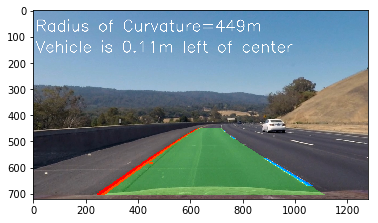

In [13]:
# For project_video.mp4

# Get correct transformation matrix
warp_base = mpimg.imread('project_warp.jpg') # This is the 
M, M_inv = get_warp_mat(warp_base, vis = False, tl_adj=1, tr_adj=-1)

# Set the pixel to meters covertion rate
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in x dimension
proc = Processor(mtx, dist_coef, M, M_inv, color_mask, xm_per_pix, ym_per_pix)
myimage = mpimg.imread('test_images/test3.jpg')
proc_image = proc.process_image(myimage)
mpimg.imsave('./output_images/processed_frame.jpg', proc_image)
plt.imshow(proc_image)

In [14]:
# Get correct transformation matrix
warp_base = mpimg.imread('project_warp.jpg')
M, M_inv = get_warp_mat(warp_base, vis = False, tl_adj=1, tr_adj=-1)

ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in x dimension
proc = Processor(mtx, dist_coef, M, M_inv, color_mask, xm_per_pix, ym_per_pix)
project_output = 'project_out.mp4'
clip2 = VideoFileClip('project_video.mp4')#.subclip(20,25)
output_clip = clip2.fl_image(proc.process_image)
%time output_clip.write_videofile(project_output, audio=False)

[MoviePy] >>>> Building video output_images/project_out.mp4
[MoviePy] Writing video output_images/project_out.mp4


100%|█████████████████████████████████████▉| 1260/1261 [01:57<00:00, 10.44it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_images/project_out.mp4 

Wall time: 1min 58s


Source points: [[  339.   692.]
 [ 1072.   692.]
 [  752.   496.]
 [  581.   496.]]
Destination points: [[ 300.  715.]
 [ 980.  715.]
 [ 980.  400.]
 [ 300.  400.]]


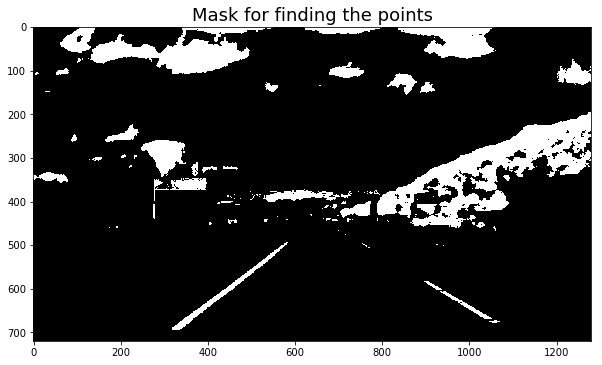

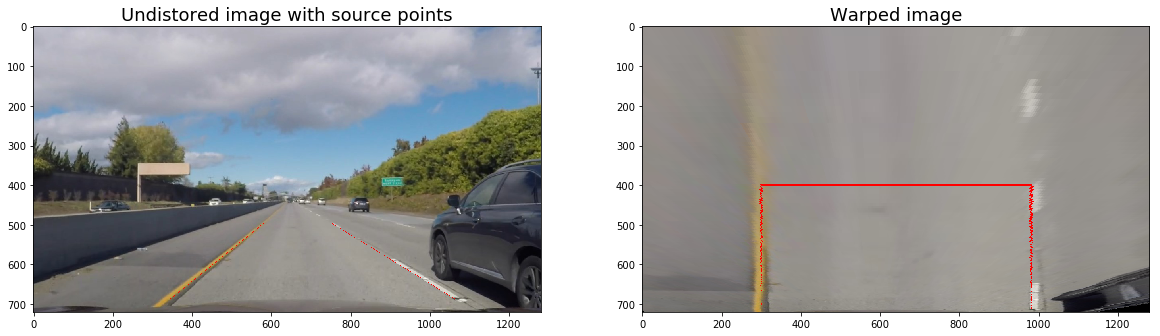

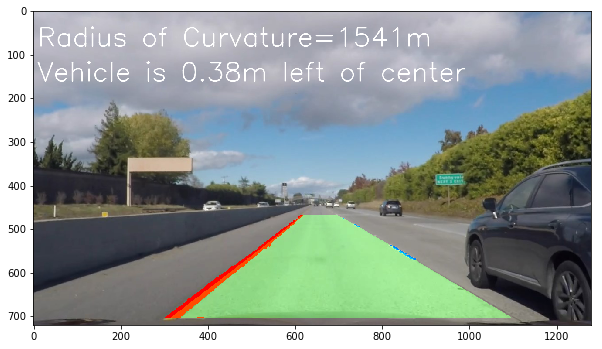

In [15]:
warp_base = mpimg.imread('challenge_warp.jpg')
M, M_inv = get_warp_mat(warp_base, vis = True, tl_adj=-1, tr_adj=-3) # show the warped image for the challenge video
ym_per_pix = 30/720# 3/81 # meters per pixel in y dimension
xm_per_pix = 3.7/700#3.7/680 # meters per pixel in x dimension
# we project the 734 pixels between the lanes onto 680 pixels and the center of the image
# is 67 pixels to the left of the center of the line between the two lanes
off_center_correction = (734/680)*67 
proc = Processor(mtx, dist_coef, M, M_inv, color_mask, xm_per_pix, ym_per_pix, off_center_correction)
myimage = mpimg.imread('./test_images/challenge_frame3.jpg')
proc_image = proc.process_image(myimage)
mpimg.imsave('./output_images/processed_challenge.jpg', proc_image)
fig, ax = plt.subplots(1,1,figsize=(10,10))
ax.imshow(proc_image)

In [17]:
warp_base = mpimg.imread('challenge_warp.jpg')
M, M_inv = get_warp_mat(warp_base, vis = False, tl_adj=-1, tr_adj=-3)
ym_per_pix = 30/720# 3/81 # meters per pixel in y dimension
xm_per_pix = 3.7/700#3.7/680 # meters per pixel in x dimension
# we project the 734 pixels between the lanes onto 680 pixels and the center of the image
# is 67 pixels to the left of the center of the line between the two lanes
off_center_correction = (734/680)*67 
proc = Processor(mtx, dist_coef, M, M_inv, color_mask, xm_per_pix, ym_per_pix, off_center_correction)
project_output = 'challenge_out.mp4'
clip2 = VideoFileClip('challenge_video.mp4')#.subclip(20,25)
output_clip = clip2.fl_image(proc.process_image)
%time output_clip.write_videofile(project_output, audio=False)

[MoviePy] >>>> Building video output_images/challenge_out.mp4
[MoviePy] Writing video output_images/challenge_out.mp4


100%|████████████████████████████████████████| 485/485 [00:42<00:00, 11.49it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_images/challenge_out.mp4 

Wall time: 42.8 s


### Video display

In [20]:
from IPython.display import HTML

HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format('project_out.mp4'))

In [21]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format('challenge_out.mp4'))